# 1. Improt  and Install Dependencies

In [5]:
# !pip install tensorflow opencv-python mediapipe sklearn matplotlib

In [6]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import  mediapipe  as mp

# 2. Keypoint using MP Holistic

In [7]:
mp_holistic = mp.solutions.holistic # Holistic Model
mp_drawing  = mp.solutions.drawing_utils # Drawing utilities

In [8]:
def  mediapipe_detection(image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) #converting color
    image.flags.writeable = False # Image is no longer writeable
    results = model.process(image) #make prediction
    image.flags.writeable = True # Image is now writeable
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR) #converting color
    return image,results

# This is optional now,The one being used is the draw_styled_landmarks.

In [9]:
def draw_styled_landmarks(image, result):
    mp_drawing.draw_landmarks(image,result.pose_landmarks,mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(250,250,250), thickness = 2, circle_radius = 2),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness = 1, circle_radius = 1)) # Draw pose conections
    mp_drawing.draw_landmarks(image,result.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS) # Draw left Hand conections
    mp_drawing.draw_landmarks(image,result.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS) # Draw Right Hand conection.

# Optional {For testing the camera and detection mechanisim}

In [10]:
# cap  = cv2.VideoCapture(1)
# # Accessing mediapipe model
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence = 0.5) as holistic:
#     while cap.isOpened():
        
#         # Read feed
#         ret,frame = cap.read()

#         # Make detection
#         image, results = mediapipe_detection(frame,holistic)
        
        
#         # Draw  landmarks
#         draw_styled_landmarks(image,results)
        

#         cv2.imshow('RSL Feed', image)
#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             break
#     cap.release()
#     cv2.destroyAllWindows()

# 3. Extract Keypoint Values

In [11]:

# With out Face points  multiple left and hand cordinates to increase accuracy
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    # magnifiying the hands value for better accuracy
    return np.concatenate([pose, lh, rh, lh, rh, lh, rh, lh, rh, lh, rh, lh, rh, lh, rh, lh, rh, lh, rh, lh, rh])

# 4. Setup Folders for Collection 

In [12]:
# Output will be  arrray containing numerical values for the extracted keypoints
# Path to outr external data
DATA_PATH = os.path.join('..', 'new_models/Data')  # Adjust path as needed


# Check if the folder exists
if os.path.isdir(DATA_PATH):
    print("Folder exists:", DATA_PATH)
else:
    print("Folder NOT found:", DATA_PATH)



Folder exists: ..\new_models/Data


In [13]:
# Get all action folders from the external dataset
action_folders = [f for f in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, f))]
actions = np.array(sorted(action_folders))  # Sort for consistency

print(f"Found {len(actions)} actions in the dataset:")
print(actions)


Found 15 actions in the dataset:
['---' 'akarere' 'akazi' 'amakuru' 'bayi' 'bibi' 'igihugu' 'neza'
 'nyarugenge' 'oya' 'papa' 'umujyi wa kigali' 'umurenge' 'urakoze' 'yego']


In [14]:

# Auto-detect number of sequences and frames
sample_action = actions[0]
sample_path = os.path.join(DATA_PATH, sample_action)
sequences_in_action = [d for d in os.listdir(sample_path) if os.path.isdir(os.path.join(sample_path, d))]
no_sequences = len(sequences_in_action)

# Check frames in first sequence
first_sequence_path = os.path.join(sample_path, sequences_in_action[0])
npy_files = [f for f in os.listdir(first_sequence_path) if f.endswith('.npy')]
sequence_length = len(npy_files)

print(f"\nDataset Info:")
print(f"- Number of sequences per action: {no_sequences}")
print(f"- Frames per sequence: {sequence_length}")

print(" Now we have a total of {} videos from all actions.".format(len(actions)*no_sequences))


Dataset Info:
- Number of sequences per action: 40
- Frames per sequence: 30
 Now we have a total of 600 videos from all actions.


In [15]:
# Inspect the data structure
import glob

print("=" * 60)
print("DATA STRUCTURE INSPECTION")
print("=" * 60)

for action in actions[:3]:  # Check first 3 actions
    action_path = os.path.join(DATA_PATH, action)
    sequences = sorted([d for d in os.listdir(action_path) if os.path.isdir(os.path.join(action_path, d))])
    
    print(f"\nAction: {action}")
    print(f"  Total sequences: {len(sequences)}")
    
    # Check first sequence
    if sequences:
        first_seq_path = os.path.join(action_path, sequences[0])
        npy_files = sorted([f for f in os.listdir(first_seq_path) if f.endswith('.npy')])
        
        print(f"  First sequence: {sequences[0]}")
        print(f"    Number of .npy files: {len(npy_files)}")
        
        # Load one file to check shape
        if npy_files:
            sample_file = os.path.join(first_seq_path, npy_files[0])
            sample_data = np.load(sample_file)
            print(f"    Sample file shape: {sample_data.shape}")
            print(f"    Feature dimensions: {sample_data.shape[0] if len(sample_data.shape) == 1 else sample_data.shape}")

print("\n" + "=" * 60)

DATA STRUCTURE INSPECTION

Action: ---
  Total sequences: 40
  First sequence: 1
    Number of .npy files: 30
    Sample file shape: (1518,)
    Feature dimensions: 1518

Action: akarere
  Total sequences: 40
  First sequence: 1
    Number of .npy files: 30
    Sample file shape: (1518,)
    Feature dimensions: 1518

Action: akazi
  Total sequences: 40
  First sequence: 1
    Number of .npy files: 30
    Sample file shape: (1518,)
    Feature dimensions: 1518



# 5. Collect Keypoint Values for Training and Testing

# SKIPPED
**Note:** Data collection is skipped because we're using pre-existing `.npy` files from the external dataset.

# 6. Preprocess External Data and Create Labels and Features


In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [17]:
# Create label map
label_map = {label: num for num, label in enumerate(actions)}
print("Label Mapping:")
for label, num in label_map.items():
    print(f"  {num}: {label}")

# Load sequences and labels
sequences, labels = [], []
missing_data = []
padded_sequences = []
truncated_sequences = []

print("\nLoading data...")
for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    
    # Get all sequence folders
    sequence_folders = sorted([d for d in os.listdir(action_path) 
                               if os.path.isdir(os.path.join(action_path, d))])
    
    for sequence_folder in sequence_folders:
        sequence_path = os.path.join(action_path, sequence_folder)
        window = []
        
        try:
            # Get all .npy files in sequence
            npy_files = sorted([f for f in os.listdir(sequence_path) if f.endswith('.npy')])
            
            # Check if sequence length matches
            actual_length = len(npy_files)
            
            # Load each frame
            for npy_file in npy_files:
                npy_path = os.path.join(sequence_path, npy_file)
                res = np.load(npy_path)
                window.append(res)
            
            # Handle different sequence lengths
            if actual_length < sequence_length:
                # PAD: Add zero frames to match sequence_length
                feature_dim = len(window[0])
                padding_needed = sequence_length - actual_length
                for _ in range(padding_needed):
                    window.append(np.zeros(feature_dim))
                padded_sequences.append(f"{action}/{sequence_folder} - Padded {padding_needed} frames")
                
            elif actual_length > sequence_length:
                # TRUNCATE: Keep only first sequence_length frames
                window = window[:sequence_length]
                truncated_sequences.append(f"{action}/{sequence_folder} - Truncated from {actual_length} to {sequence_length}")
            
            # Add to sequences (all data included now)
            sequences.append(window)
            labels.append(label_map[action])
            
        except Exception as e:
            missing_data.append(f"{action}/{sequence_folder} - Error: {str(e)}")
            continue

print(f"\n{'='*60}")
print(f"DATA LOADING SUMMARY")
print(f"{'='*60}")
print(f"✓ Loaded {len(sequences)} sequences successfully")
print(f"  - Padded sequences: {len(padded_sequences)}")
print(f"  - Truncated sequences: {len(truncated_sequences)}")
print(f"  - Failed sequences: {len(missing_data)}")

if padded_sequences:
    print(f"\nPadded Sequences (first 5):")
    for item in padded_sequences[:5]:
        print(f"  • {item}")
    if len(padded_sequences) > 5:
        print(f"  ... and {len(padded_sequences) - 5} more")

if truncated_sequences:
    print(f"\nTruncated Sequences (first 5):")
    for item in truncated_sequences[:5]:
        print(f"  • {item}")
    if len(truncated_sequences) > 5:
        print(f"  ... and {len(truncated_sequences) - 5} more")

if missing_data:
    print(f"\n⚠️ Failed to Load ({len(missing_data)} sequences):")
    for item in missing_data[:10]:
        print(f"  ✗ {item}")
    if len(missing_data) > 10:
        print(f"  ... and {len(missing_data) - 10} more")

print(f"\n{'='*60}")

Label Mapping:
  0: ---
  1: akarere
  2: akazi
  3: amakuru
  4: bayi
  5: bibi
  6: igihugu
  7: neza
  8: nyarugenge
  9: oya
  10: papa
  11: umujyi wa kigali
  12: umurenge
  13: urakoze
  14: yego

Loading data...

DATA LOADING SUMMARY
✓ Loaded 600 sequences successfully
  - Padded sequences: 0
  - Truncated sequences: 249
  - Failed sequences: 0

Truncated Sequences (first 5):
  • nyarugenge/1 - Truncated from 60 to 30
  • nyarugenge/10 - Truncated from 60 to 30
  • nyarugenge/11 - Truncated from 60 to 30
  • nyarugenge/12 - Truncated from 60 to 30
  • nyarugenge/13 - Truncated from 60 to 30
  ... and 244 more



In [18]:
# Verify loaded data
print("\nData Shapes:")
print(f"Sequences array shape: {np.array(sequences).shape}")
print(f"Labels array shape: {np.array(labels).shape}")

# Check feature dimensions
if len(sequences) > 0:
    print(f"\nFeature dimensions per frame: {len(sequences[0][0])}")
    print(f"Expected: 1392 (Phase 3 with magnified hands)")
    
    # Distribution of labels
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("\nLabel Distribution:")
    for label_idx, count in zip(unique_labels, counts):
        action_name = actions[label_idx]
        print(f"  {action_name}: {count} sequences")


Data Shapes:
Sequences array shape: (600, 30, 1518)
Labels array shape: (600,)

Feature dimensions per frame: 1518
Expected: 1392 (Phase 3 with magnified hands)

Label Distribution:
  ---: 40 sequences
  akarere: 40 sequences
  akazi: 40 sequences
  amakuru: 40 sequences
  bayi: 40 sequences
  bibi: 40 sequences
  igihugu: 40 sequences
  neza: 40 sequences
  nyarugenge: 40 sequences
  oya: 40 sequences
  papa: 40 sequences
  umujyi wa kigali: 40 sequences
  umurenge: 40 sequences
  urakoze: 40 sequences
  yego: 40 sequences


# 7. Convert to arrays and split

In [19]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

print(f"\nFinal shapes:")
print(f"X (features): {X.shape}")  # Should be (num_sequences, 30, feature_dim)
print(f"y (labels): {y.shape}")    # Should be (num_sequences, num_actions)

# Get actual feature dimensions
actual_feature_dim = X.shape[2]
print(f"\nActual feature dimensions: {actual_feature_dim}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=labels)

print(f"\nTrain-Test Split:")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")


Final shapes:
X (features): (600, 30, 1518)
y (labels): (600, 15)

Actual feature dimensions: 1518

Train-Test Split:
Training samples: 420
Testing samples: 180


# 8. Build Model with Correct Input Shape


In [20]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import regularizers

# Setup callbacks
log_dir = os.path.join('Logs_External_Data')
tb_callback = TensorBoard(log_dir=log_dir)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Optimizer
opt = Adam(learning_rate=0.00001)

# Model architecture - UPDATE INPUT SHAPE
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu',
               kernel_regularizer=regularizers.l2(0.01), 
               input_shape=(sequence_length, actual_feature_dim)))  # Use actual dimensions
model.add(LSTM(128, return_sequences=True, activation='relu', 
               kernel_regularizer=regularizers.l2(0.01)))
model.add(LSTM(64, return_sequences=False, activation='relu', 
               kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(len(actions), activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

# Compile
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Summary
model.summary()

C:\Users\STUDENT\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │       405,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,207 (2.14 MB)

 Trainable params: 560,207 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

# 9. Train the model

In [21]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=200,
    validation_data=(X_test, y_test),  # Use test set for validation
    callbacks=[tb_callback, early_stop],
    batch_size=32,
    verbose=1
)


Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - categorical_accuracy: 0.0676 - loss: 11.1837 - val_categorical_accuracy: 0.0667 - val_loss: 11.1574
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - categorical_accuracy: 0.0732 - loss: 11.1397 - val_categorical_accuracy: 0.0722 - val_loss: 11.1162
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - categorical_accuracy: 0.0591 - loss: 11.1026 - val_categorical_accuracy: 0.0667 - val_loss: 11.0747
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - categorical_accuracy: 0.0705 - loss: 11.0539 - val_categorical_accuracy: 0.0667 - val_loss: 11.0331
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - categorical_accuracy: 0.0928 - loss: 10.9993 - val_categorical_accuracy: 0.0778 - val_loss: 10.9927
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - categorical_accuracy: 0.0700 - loss: 10.9702 - val_categorical_accuracy: 0.0778 - val_loss: 10.9516
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - categorical_ac

## Plot training history

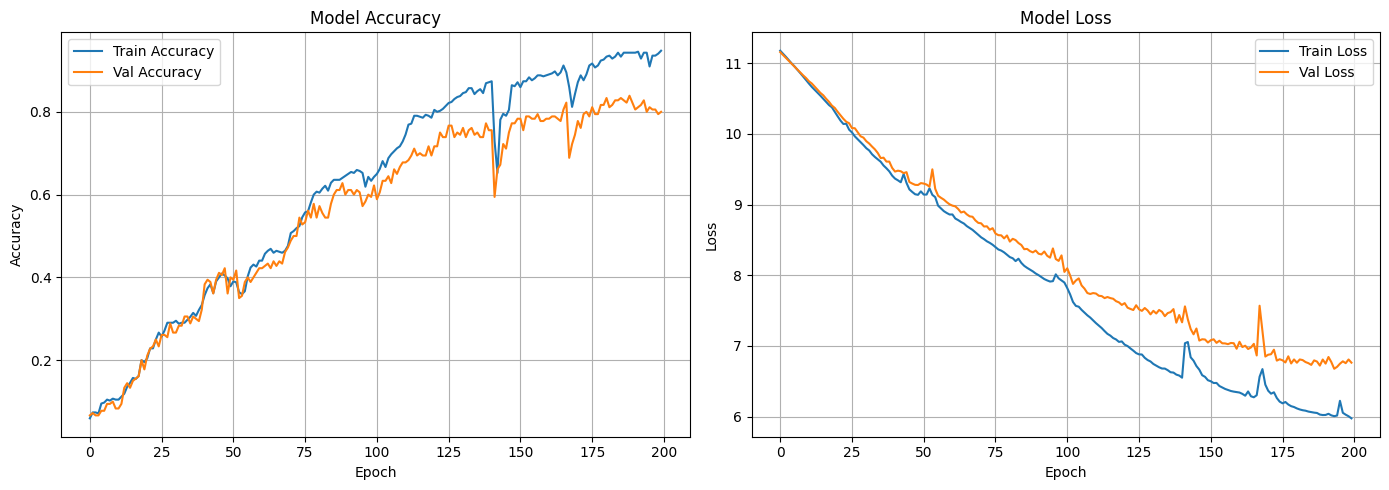

In [22]:


plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Model saving

In [23]:
# model.save('RSL Action Detection Script_phase3.h5')

10. Prediction

In [24]:
results = model.predict(X_test)

# Convert from one-hot back to labels
y_pred = np.argmax(results, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print first example
print("Predicted:", actions[y_pred[0]])
print("Actual:   ", actions[y_true[0]])

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step
Predicted: bibi
Actual:    yego


In [25]:
print("Model output classes:", model.output_shape[-1])

Model output classes: 15


In [26]:
print("Model output classes:", model.output_shape[-1])
print("Actions list length:", len(actions))

Model output classes: 15
Actions list length: 15


Evaluation metrics

In [27]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)


Accuracy: 0.8277777777777777


In [28]:
class_names = actions
from sklearn.metrics import confusion_matrix
# Obtain the confusion matrix
used_classes = np.unique(y_true)
class_names_used = actions[used_classes]


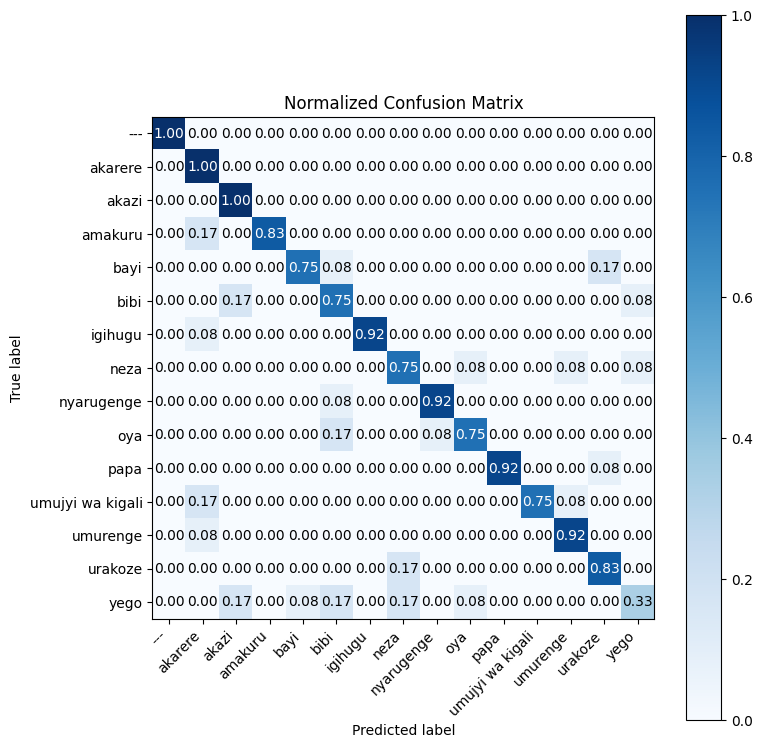

In [29]:
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
plt.imshow(cm_norm, cmap='Blues', vmin=0, vmax=1)

plt.xticks(np.arange(len(used_classes)), class_names_used, rotation=45, ha='right')
plt.yticks(np.arange(len(used_classes)), class_names_used)

# Add annotation inside boxes
for i in range(len(used_classes)):
    for j in range(len(used_classes)):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                 ha='center', va='center',
                 color="white" if cm_norm[i, j] > 0.5 else "black")

plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.tight_layout()
plt.show()



In [30]:
import numpy as np

# Convert from one-hot
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(results, axis=1)

per_class_accuracy = []
for i in range(len(actions)):
    indices = np.where(y_true_labels == i)[0]
    if len(indices) == 0:
        per_class_accuracy.append(0)
    else:
        acc = np.mean(y_true_labels[indices] == y_pred_labels[indices])
        per_class_accuracy.append(acc)



In [31]:
print("{:<20} {}".format("Label", "Accuracy"))
print("-" * 35)

for label, acc in zip(actions, per_class_accuracy):
    print("{:<20} {:.2f}".format(label, acc))

print("\nAverage Accuracy {:.2f}".format(np.mean(per_class_accuracy)))


Label                Accuracy
-----------------------------------
---                  1.00
akarere              1.00
akazi                1.00
amakuru              0.83
bayi                 0.75
bibi                 0.75
igihugu              0.92
neza                 0.75
nyarugenge           0.92
oya                  0.75
papa                 0.92
umujyi wa kigali     0.75
umurenge             0.92
urakoze              0.83
yego                 0.33

Average Accuracy 0.83


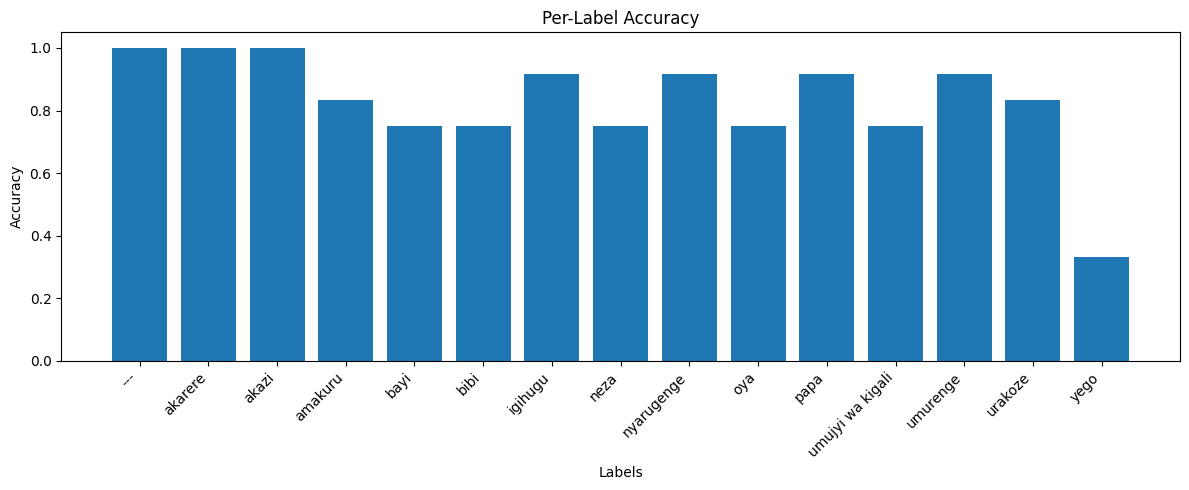

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.bar(actions, per_class_accuracy)
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1.05])
plt.title("Per-Label Accuracy")
plt.xlabel("Labels")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()


In [47]:
# Add both precision recall and F1 score for  LSTM Model
from sklearn.metrics import classification_report
print("\nCLASSIFICATION REPORT:")
report = classification_report(y_true, y_pred, target_names=actions)
print(report)


CLASSIFICATION REPORT:
                  precision    recall  f1-score   support

             ---       1.00      1.00      1.00        12
         akarere       1.00      0.92      0.96        12
           akazi       1.00      1.00      1.00        12
         amakuru       1.00      1.00      1.00        12
            bayi       1.00      1.00      1.00        12
            bibi       0.92      1.00      0.96        12
         igihugu       1.00      1.00      1.00        12
            neza       0.83      0.83      0.83        12
      nyarugenge       0.92      1.00      0.96        12
             oya       1.00      1.00      1.00        12
            papa       1.00      1.00      1.00        12
umujyi wa kigali       1.00      1.00      1.00        12
        umurenge       0.92      1.00      0.96        12
         urakoze       1.00      1.00      1.00        12
            yego       1.00      0.83      0.91        12

        accuracy                           0.9

BiLSTM+Attention

In [33]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Layer
from tensorflow.keras.optimizers import Adam

# ---- Attention layer ----
class Attention(Layer):
    def __init__(self, attn_units):
        super(Attention, self).__init__()
        self.attn_units = attn_units

    def build(self, input_shape):
        # input_shape: (batch, time, features)
        self.W = self.add_weight(
            name="attn_W",
            shape=(input_shape[-1], self.attn_units),
            initializer="glorot_uniform",
            trainable=True,
        )
        self.b = self.add_weight(
            name="attn_b",
            shape=(self.attn_units,),
            initializer="zeros",
            trainable=True,
        )
        self.v = self.add_weight(
            name="attn_v",
            shape=(self.attn_units, 1),
            initializer="glorot_uniform",
            trainable=True,
        )
        super().build(input_shape)

    def call(self, inputs):
        # inputs: (batch, time, features)
        # score shape: (batch, time, attn_units)
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        # attention weights: (batch, time, 1) -> (batch, time)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.v, axes=1), axis=1)
        attention_weights = tf.squeeze(attention_weights, axis=-1)

        # context vector: weighted sum over time -> (batch, features)
        context_vector = tf.reduce_sum(
            tf.expand_dims(attention_weights, -1) * inputs, axis=1
        )
        return context_vector, attention_weights


# ---- BiLSTM + Attention model ----
sequence_length = 30      # same as before
feature_dim     = 1518    # same as before
num_classes     = len(actions)

inputs = Input(shape=(sequence_length, feature_dim), name="input_seq")

# BiLSTM stack
x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
x = Bidirectional(LSTM(128, return_sequences=True))(x)

# Attention over time
context_vector, attn_weights = Attention(attn_units=128)(x)

# Classification head
x = Dense(128, activation='relu')(context_vector)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax', name="softmax")(x)

model = Model(inputs=inputs, outputs=outputs, name="BiLSTM_Attention")

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

model.summary()


Model: "BiLSTM_Attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_seq (InputLayer)          │ (None, 30, 1518)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │     1,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ [(None, 256), (None,   │        33,024 │
│                                 │ 30)]                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,148,623 (8.20 MB)

 Trainable params: 2,148,623 (8.20 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    validation_data=(X_test, y_test),
    callbacks=[tb_callback, early_stop],  # if you already defined these
    batch_size=32,
    verbose=1
)


Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 715ms/step - categorical_accuracy: 0.1001 - loss: 2.6870 - val_categorical_accuracy: 0.2278 - val_loss: 2.5180
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 416ms/step - categorical_accuracy: 0.1838 - loss: 2.5170 - val_categorical_accuracy: 0.2944 - val_loss: 2.3704
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - categorical_accuracy: 0.2678 - loss: 2.3531 - val_categorical_accuracy: 0.4556 - val_loss: 2.2311
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 347ms/step - categorical_accuracy: 0.2868 - loss: 2.2308 - val_categorical_accuracy: 0.4833 - val_loss: 2.0588
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - categorical_accuracy: 0.4021 - loss: 2.0442 - val_categorical_accuracy: 0.5667 - val_loss: 1.8877
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 347ms/step - categorical_accuracy: 0.4755 - loss: 1.8782 - val_categorical_accuracy: 0.5889 - val_loss: 1.6875
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step - categorical_accuracy: 0.48

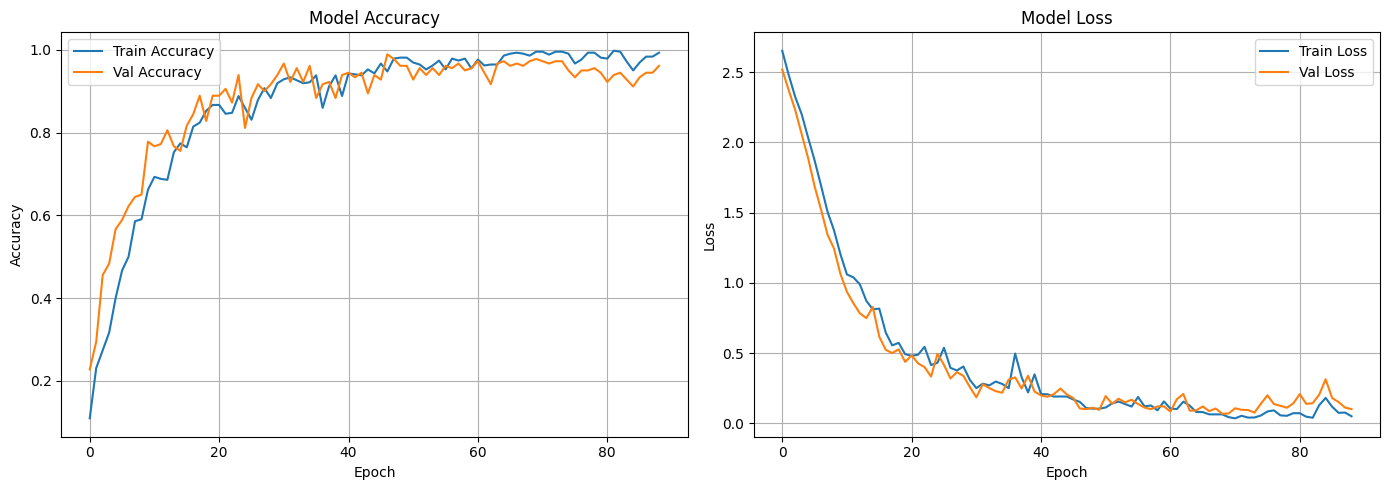

In [35]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [36]:
print("Model output classes:", model.output_shape[-1])

Model output classes: 15


In [37]:
results = model.predict(X_test)

# Convert from one-hot back to labels
y_pred = np.argmax(results, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print first example
print("Predicted:", actions[y_pred[0]])
print("Actual:   ", actions[y_true[0]])

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 582ms/step
Predicted: yego
Actual:    yego


In [38]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)


Accuracy: 0.9722222222222222


In [39]:
class_names = actions
from sklearn.metrics import confusion_matrix
# Obtain the confusion matrix
used_classes = np.unique(y_true)
class_names_used = actions[used_classes]


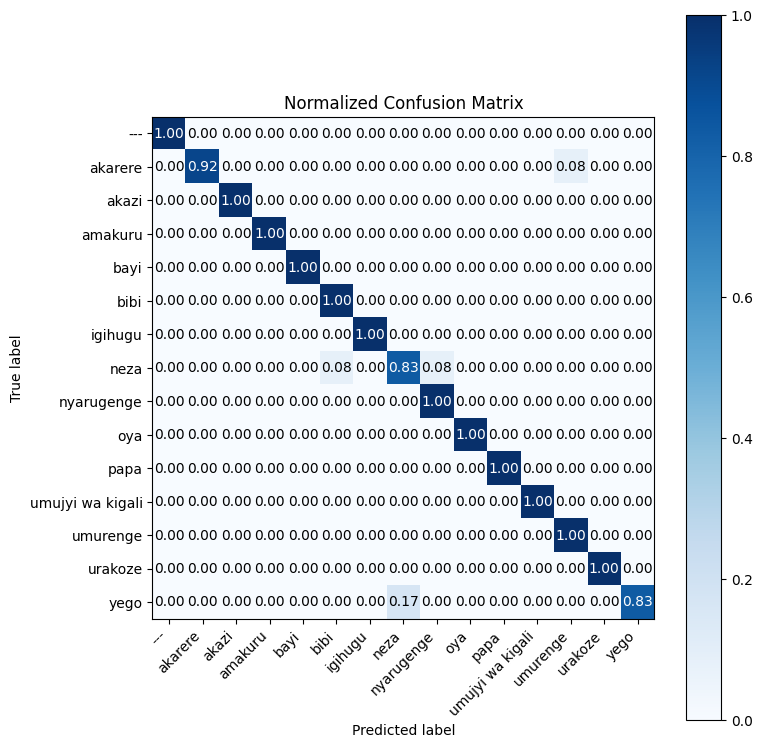

In [40]:
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
plt.imshow(cm_norm, cmap='Blues', vmin=0, vmax=1)

plt.xticks(np.arange(len(used_classes)), class_names_used, rotation=45, ha='right')
plt.yticks(np.arange(len(used_classes)), class_names_used)

# Add annotation inside boxes
for i in range(len(used_classes)):
    for j in range(len(used_classes)):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                 ha='center', va='center',
                 color="white" if cm_norm[i, j] > 0.5 else "black")

plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.tight_layout()
plt.show()



In [41]:
import numpy as np

# Convert from one-hot
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(results, axis=1)

per_class_accuracy = []
for i in range(len(actions)):
    indices = np.where(y_true_labels == i)[0]
    if len(indices) == 0:
        per_class_accuracy.append(0)
    else:
        acc = np.mean(y_true_labels[indices] == y_pred_labels[indices])
        per_class_accuracy.append(acc)

In [42]:
print("{:<20} {}".format("Label", "Accuracy"))
print("-" * 35)

for label, acc in zip(actions, per_class_accuracy):
    print("{:<20} {:.2f}".format(label, acc))

print("\nAverage Accuracy {:.2f}".format(np.mean(per_class_accuracy)))

Label                Accuracy
-----------------------------------
---                  1.00
akarere              0.92
akazi                1.00
amakuru              1.00
bayi                 1.00
bibi                 1.00
igihugu              1.00
neza                 0.83
nyarugenge           1.00
oya                  1.00
papa                 1.00
umujyi wa kigali     1.00
umurenge             1.00
urakoze              1.00
yego                 0.83

Average Accuracy 0.97


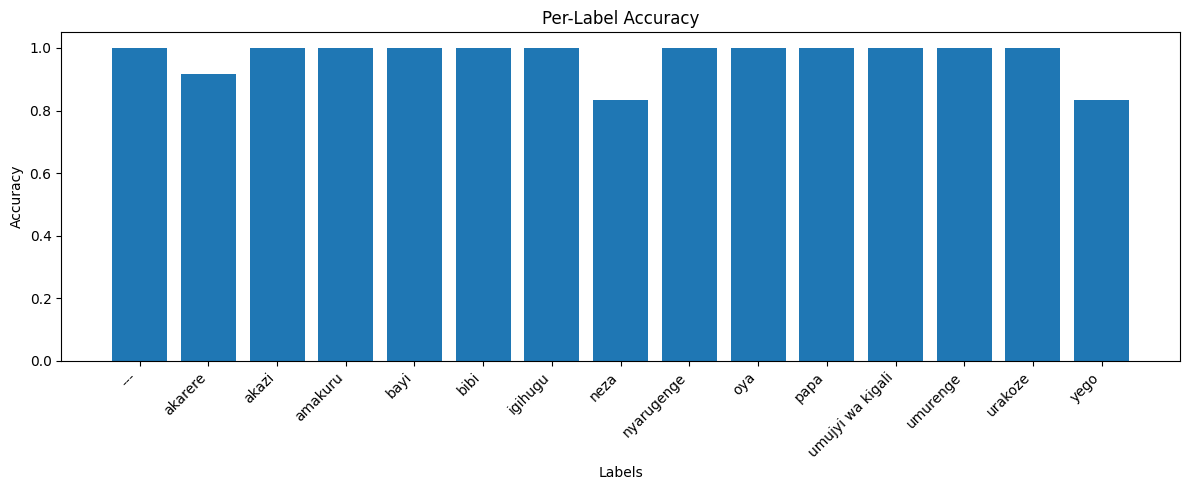

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.bar(actions, per_class_accuracy)
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1.05])
plt.title("Per-Label Accuracy")
plt.xlabel("Labels")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

In [45]:
# Add this cell after your BiLSTM training to get the summary

print(f"\n{'='*50}")
print(f"BiLSTM+ATTENTION TRAINING SUMMARY")
print(f"{'='*50}")
print(f"Final Training Accuracy:      {history.history['categorical_accuracy'][-1]*100:.2f}%")
print(f"Final Validation Accuracy:    {history.history['val_categorical_accuracy'][-1]*100:.2f}%")
print(f"Final Training Loss:          {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss:        {history.history['val_loss'][-1]:.4f}")
print(f"Total Epochs Trained:         {len(history.history['loss'])}")
print(f"{'='*50}")

# Best epoch metrics (if early stopping was used)
best_epoch = np.argmin(history.history['val_loss'])
print(f"\nBEST EPOCH METRICS (Epoch {best_epoch + 1}):")
print(f"Training Accuracy:            {history.history['categorical_accuracy'][best_epoch]*100:.2f}%")
print(f"Validation Accuracy:          {history.history['val_categorical_accuracy'][best_epoch]*100:.2f}%")
print(f"Training Loss:                {history.history['loss'][best_epoch]:.4f}")
print(f"Validation Loss:              {history.history['val_loss'][best_epoch]:.4f}")
print(f"{'='*50}")


BiLSTM+ATTENTION TRAINING SUMMARY
Final Training Accuracy:      99.29%
Final Validation Accuracy:    96.11%
Final Training Loss:          0.0510
Final Validation Loss:        0.1026
Total Epochs Trained:         89

BEST EPOCH METRICS (Epoch 69):
Training Accuracy:            98.57%
Validation Accuracy:          97.22%
Training Loss:                0.0649
Validation Loss:              0.0695


In [ ]:
# Add precision recall and F1 score for both LSTM and BiLSTM+Attention models

from sklearn.metrics import classification_report
print("\nCLASSIFICATION REPORT:")
report = classification_report(y_true, y_pred, target_names=actions)
print(report)





CLASSIFICATION REPORT:
                  precision    recall  f1-score   support

             ---       1.00      1.00      1.00        12
         akarere       1.00      0.92      0.96        12
           akazi       1.00      1.00      1.00        12
         amakuru       1.00      1.00      1.00        12
            bayi       1.00      1.00      1.00        12
            bibi       0.92      1.00      0.96        12
         igihugu       1.00      1.00      1.00        12
            neza       0.83      0.83      0.83        12
      nyarugenge       0.92      1.00      0.96        12
             oya       1.00      1.00      1.00        12
            papa       1.00      1.00      1.00        12
umujyi wa kigali       1.00      1.00      1.00        12
        umurenge       0.92      1.00      0.96        12
         urakoze       1.00      1.00      1.00        12
            yego       1.00      0.83      0.91        12

        accuracy                           0.9